### Scanpy analysis of 3k PBMC following a Seurat Tutorial

This reproduces some of Seurat's analysis of the PBMC data set  http://satijalab.org/seurat/pbmc-tutorial.html as compiled on March 30, 2017. The data consists in *3k PBMCs from a Healthy Donor* and is freely available from 10x ([here](https://support.10xgenomics.com/single-cell/datasets/pbmc3k), section *Chromium Demonstration (v1 Chemistry)* in [datasets](https://support.10xgenomics.com/single-cell/datasets)).

First compiled on May 5th, 2017.

In [1]:
%config InlineBackend.figure_formats = ['retina']  # increase resolution on retina screens
import numpy as np
import scanpy.api as sc
import re  # regular expression module

sc.sett.verbosity = 3                # show some output
sc.sett.set_dpi(70)                  # dots (pixels) per inch determine size of inline figures
sc.sett.file_format_figures = 'png'  # set this to 'svg' (notebook) or 'pdf' (files) if you want vector graphics
sc.sett.savefigs = False             # do not autosave figures

Output Scanpy version and date.

In [2]:
print('running Scanpy version', sc.__version__, 'on', sc.logging.get_date())

running Scanpy version 0.1+35.gb69fd6d on 2017-05-23 13:17


Load the data into an `AnnData` object `adata` which consists of the data matrix `adata.X`, sample/cell annotation `adata.smp` and variable/gene annotation `adata.var` and additional unstructured annotation `adata.add`.

For a large file, this takes a longer time only when first reading the `.mtx` text file.

Read the gene names using a standard numpy function and add it as variable annotation to `adata`.

In [3]:
filename_data = './data/pbmc3k_filtered_gene_bc_matrices/hg19/matrix.mtx'
filename_genes = './data/pbmc3k_filtered_gene_bc_matrices/hg19/genes.tsv'
filename_barcodes = './data/pbmc3k_filtered_gene_bc_matrices/hg19/barcodes.tsv'
adata = sc.read(filename_data).transpose()
adata.var_names = np.loadtxt(filename_genes, dtype='S')[:, 1]
adata.smp_names = np.loadtxt(filename_barcodes, dtype='S')

... reading file ./write/data/pbmc3k_filtered_gene_bc_matrices/hg19/matrix.h5


Basic filtering.

In [4]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

... filtered out 19024 genes that are detected in less than 3 cells


Plot some information about mitochondrial genes, important for quality control

In [5]:
mito_genes = np.array([name for name in adata.var_names
                       if bool(re.search("^MT-", name))])
# for each cell compute fraction of counts in mito genes vs. all genes
adata.smp['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as sample annotation to adata
adata.smp['n_counts'] = np.sum(adata.X, axis=1).A1

A violin plot of the computed quality measures.

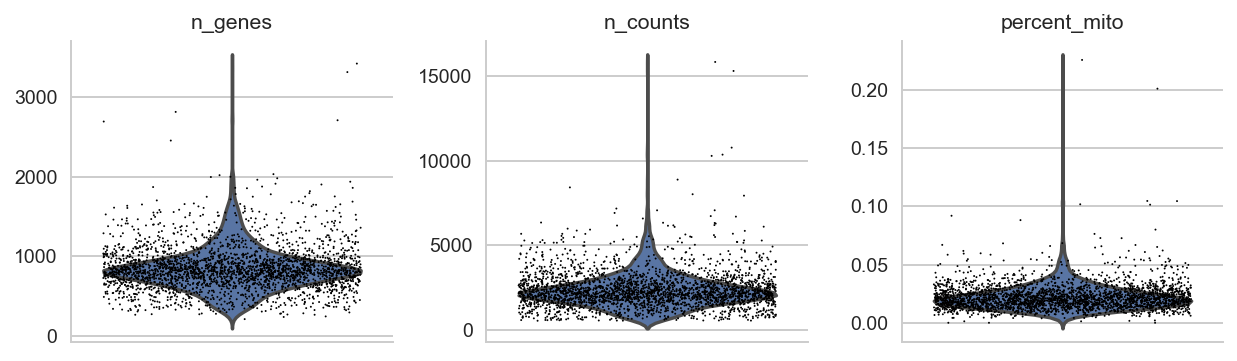

In [6]:
axs = sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, show=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts.

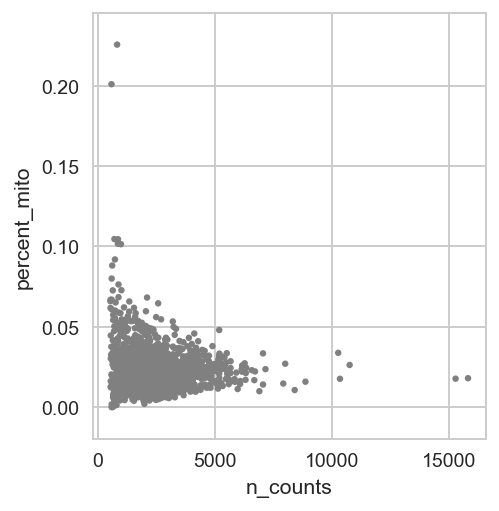

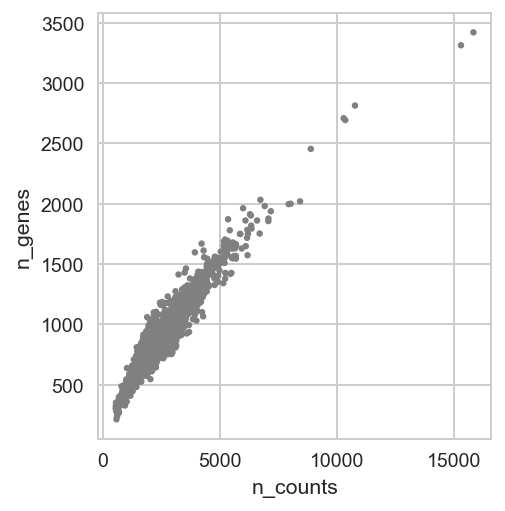

In [7]:
axs = sc.pl.scatter(adata, x='n_counts', y='percent_mito')
axs = sc.pl.scatter(adata, x='n_counts', y='n_genes', show=True)

Actually do the filtering.

In [8]:
adata = adata[adata.smp['n_genes'] < 2500, :]
adata = adata[adata.smp['percent_mito'] < 0.05, :]

Per-cell normalize the data matrix $X$, identify highly-variable genes and compute logarithm.

... normalizing by total count per cell (0:00:00.018)
... filter highly varying genes by dispersion and mean (0:00:00.128)
    using `min_disp=0.5`, `max_disp=None`, `min_mean=0.0125` and `max_mean=3`
--> set `n_top_genes` to simply select top-scoring genes instead


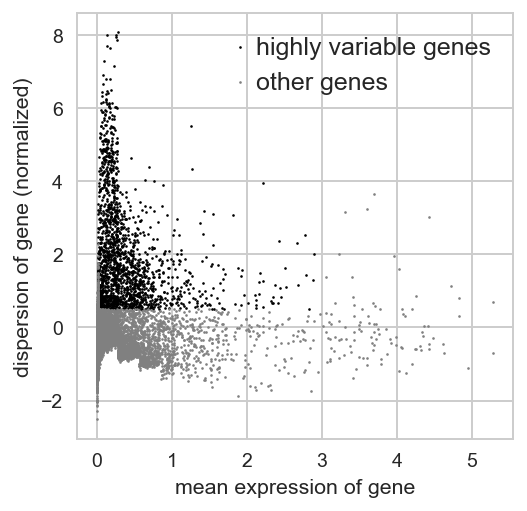

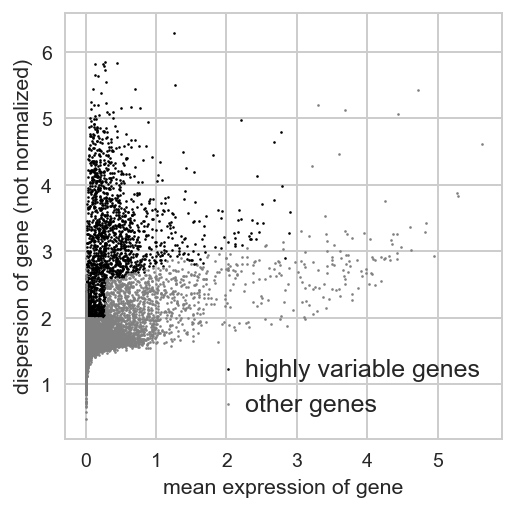

In [9]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(adata.X, log=True, flavor='seurat', min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

Actually do the filtering and logarithmize the data.

In [10]:
adata = adata[:, filter_result.gene_subset]
sc.pp.log1p(adata)

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [11]:
adata_corrected = sc.pp.regress_out(adata,
                                    smp_keys=['n_counts', 'percent_mito'],
                                    copy=True)

0:00:00.000 - regress out ['n_counts', 'percent_mito']
... sparse input is densified and may lead to huge memory consumption

0:00:06.702 - finished


Compute PCA and make a scatter plot.

In [12]:
sc.pp.scale(adata_corrected, max_value=10)

... scale_data: be very careful to use `max_value` without `zero_center`
... clipping at max_value 10


compute PCA with n_comps = 10
... finished, (0:00:00.376) adding
    the data representation "X_pca" (adata.smp)
    the loadings "PC1", "PC2", ... (adata.var)
    the "pca_variance_ratio" (adata.add)


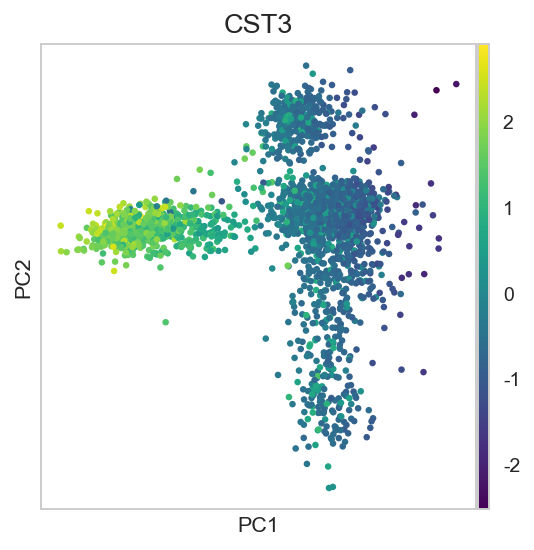

In [13]:
sc.tl.pca(adata_corrected)
adata_corrected.smp['X_pca'] *= -1  # multiply by 1 for correspondence with R
axs = sc.pl.pca_scatter(adata_corrected, color='CST3', right_margin=0.2)

Also, look at the contribution of single genes to PCs and of PCs to the total variance in the data.

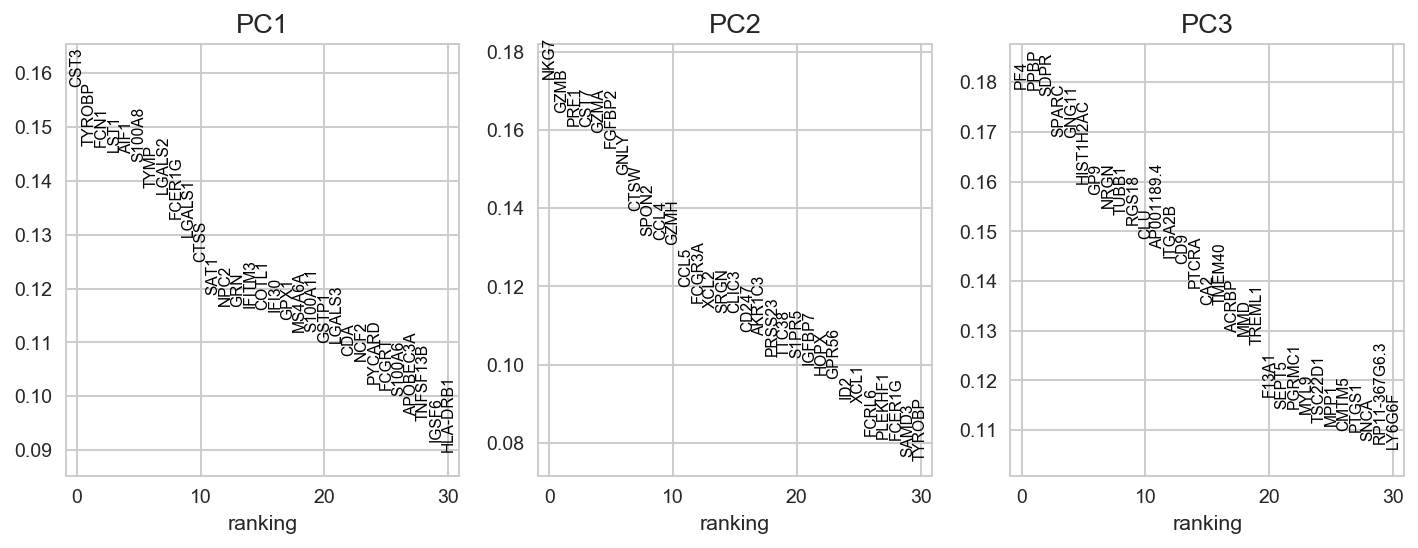

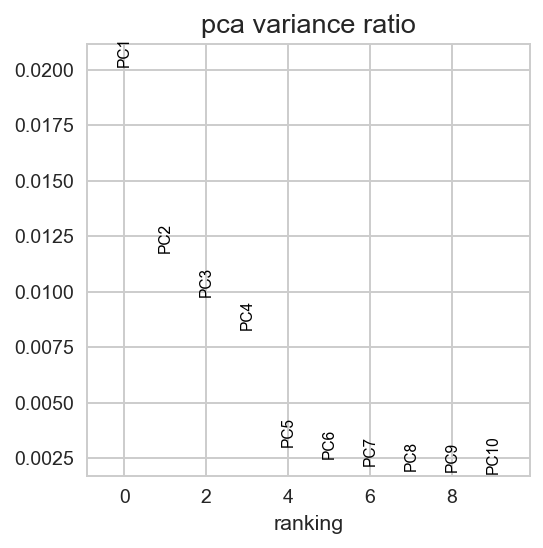

In [14]:
sc.pl.pca_ranking(adata_corrected)

In [15]:
sc.tl.tsne(adata_corrected, n_pcs=10)

compute tSNE
... using X_pca for tSNE
... using 10 principal components
... using MulticoreTSNE
finished (0:00:05.858) and added
    "X_tsne" coordinates, the tSNE representation of X (adata.smp)


Here, we use the very simple DBSCAN clustering method, similar to k-means as used in Cell Ranger (Zheng *et al.*, 2017), but for many purposes not precise enough. A better one will come soon!

In [16]:
sc.tl.dbscan(adata_corrected, basis='tsne', n_comps=2, min_samples=5)

starting DBSCAN
... the "drawing range" is 56.20648135 x 59.1007139493 with the average area per point 1.25922789096
... using eps = 1.90766050567, min_samples = 5, basis = tsne, n_comps = tsne, n_jobs = 2
--> increase `min_samples` if you find too many clusters
--> reduce eps if "everything is connected"
    finished (0:00:00.077) and found 3 clusters, added
    "dbscan_groups", the cluster labels (adata.smp)
    "dbscan_groups_names", the unique cluster labels (adata.add)


Plot the data with tSNE. Coloring according to clustering.

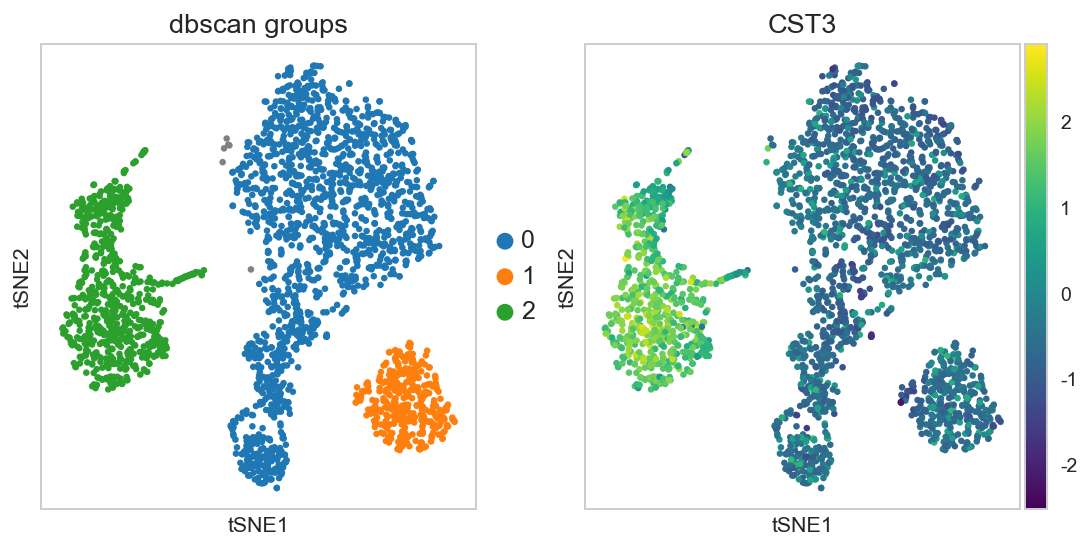

In [17]:
axs = sc.pl.tsne(adata_corrected, color=['dbscan_groups', 'CST3'])

Visualize the data using diffusion maps.

In [18]:
sc.tl.diffmap(adata_corrected, n_pcs=50)

start computing Diffusion Map
... determined k = 30 nearest neighbors of each point (0:00:00.211)
... computed W (weight matrix) with "knn" = True (0:00:01.525)
... computed K (anisotropic kernel) (0:00:00.022)
computed Ktilde (normalized anistropic kernel)
... computed eigenvalues (0:00:00.037)
[ 1.     0.988  0.978  0.925  0.879  0.845  0.835  0.717  0.615  0.599]


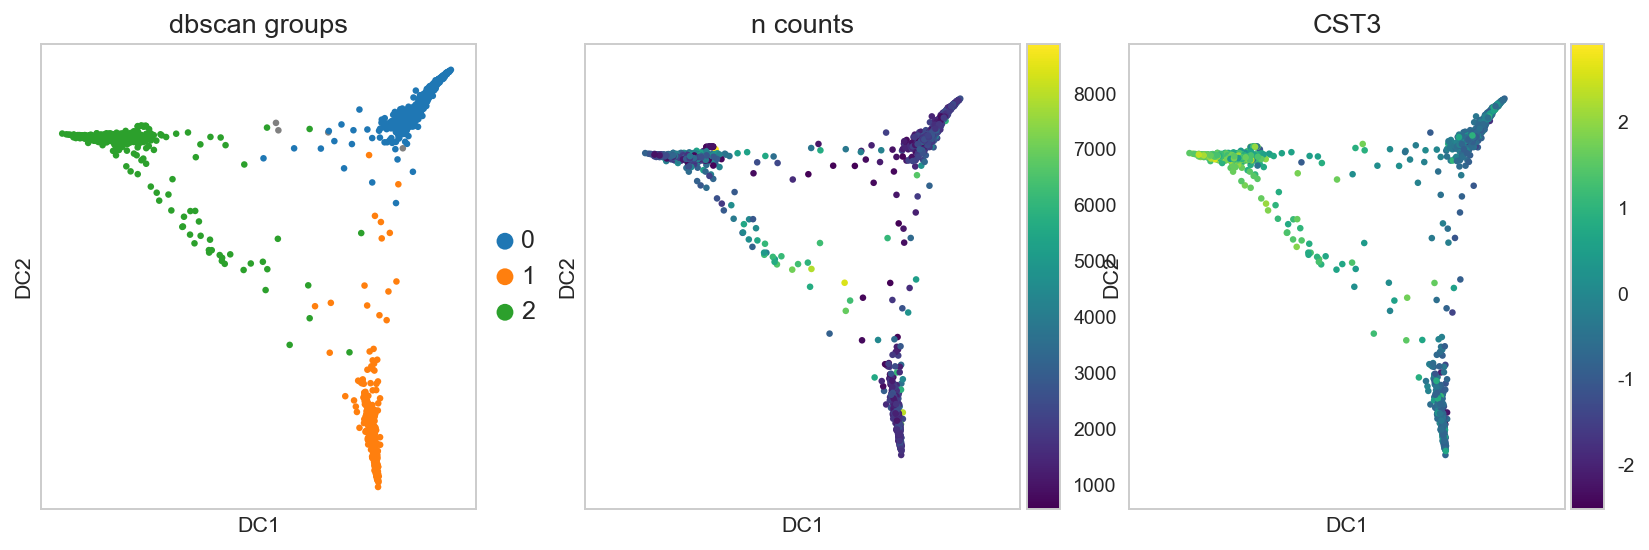

In [19]:
axs = sc.pl.diffmap(adata_corrected, color=['dbscan_groups', 'n_counts', 'CST3'])

Write the AnnData object to disk as an hdf5 file. Reload it with sc.read('seurat').

In [20]:
sc.write('seurat', adata_corrected)

... writing ./write/seurat.h5


If you want to export to "csv" or "txt", provide the file extension and write the .

In [21]:
sc.write('seurat', adata_corrected, ext='txt')

... writing txt files to ./write/seurat/
